**This notebook is an exercise in the [Time Series](https://www.kaggle.com/learn/time-series) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/hybrid-models).**

---


# Introduction #

Run this cell to set everything up!

In [1]:
# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error

comp_dir = Path('./data/store-sales-time-series-forecasting')
data_dir = Path("./data")

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

# aggregated sales by family, date
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [2]:
store_sales.sample(5)

,,,sales,onpromotion
store_nbr,family,date,,
3,PRODUCE,2013-02-08,0.000000,0
8,PRODUCE,2014-03-21,4178.393066,0
12,PERSONAL CARE,2015-08-06,141.000000,0
46,MAGAZINES,2016-06-12,16.000000,0
33,HOME CARE,2016-03-26,234.000000,0


In [3]:
family_sales.sample(5)

sales                                                          \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-12   7.462963  0.055556  6.833333  3376.259277  0.000000   507.473114   
2017-04-28   5.722222  0.166667  3.277778  3342.018555  0.111111   496.394012   
2017-03-31   6.203704  0.111111  3.851852  3493.703613  0.148148   547.955383   
2017-04-30  10.111111  0.259259  6.796296  4611.259277  0.129630   656.393677   
2017-03-14   5.277778  0.166667  2.888889  3031.185303  0.333333   506.215546   

                                                              ... onpromotion  \
family     CELEBRATION     CLEANING        DAIRY        DELI  ...   MAGAZINES   
date                                                          ...               
2017-08-12   15.722222  1072.870361   793.592590  290.553589  ...         0.0   
2017-04-28   19.833334  1171.185181   854.425903  347.357880  ...         0.0   
2017-03-31   14.537037  1193.425903   993.092590  380.281250  ...         0.0   
2017-04-30   18.314816  1596.796265  1164.296265  405.478577  ...         0.0   
2017-03-14   11.296296   922.092590   775.259277  257.199493  ...         0.0   

                                                                          \
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2017-08-12   0.000000      8.703704     0.000000                0.018519   
2017-04-28  23.018519     14.185185     0.388889                0.055556   
2017-03-31  22.796296     10.537037     0.000000                0.000000   
2017-04-30   0.185185     15.240741     0.370370                0.037037   
2017-03-14   0.000000      7.407407     0.240741                0.018519   

                                                                            \
family        POULTRY PREPARED FOODS    PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                         
2017-08-12   0.111111       0.277778   6.000000                   2.759259   
2017-04-28  26.981481       0.000000   6.333333                   2.055556   
2017-03-31  27.055556       0.351852   1.444444                   1.425926   
2017-04-30   0.074074       0.000000   6.407407                   2.351852   
2017-03-14   0.074074       0.203704  55.166667                   0.000000   

                      
family       SEAFOOD  
date                  
2017-08-12  0.759259  
2017-04-28  2.666667  
2017-03-31  2.592593  
2017-04-30  0.000000  
2017-03-14  0.259259  

[5 rows x 66 columns]

-------------------------------------------------------------------------------

In the next two questions, you'll create a boosted hybrid for the *Store Sales* dataset by implementing a new Python class. Run this cell to create the initial class definition. You'll add `fit` and `predict` methods to give it a scikit-learn like interface.


In [4]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    '''Pass in the model instances to be used (ex. LinearRegression(), XGBRegressor())'''
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

# 1) Define fit method for boosted hybrid

Complete the `fit` definition for the `BoostedHybrid` class. Refer back to steps 1 and 2 from the **Hybrid Forecasting with Residuals** section in the tutorial if you need.

In [5]:
def fit(self, X_1, X_2, y):
    # fit self.model_1
    self.model_1.fit(X_1, y)

    # make predictions with self.model_1 to compute residuals
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    # compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns


# Add method to class
BoostedHybrid.fit = fit

-------------------------------------------------------------------------------

# 2) Define predict method for boosted hybrid

Now define the `predict` method for the `BoostedHybrid` class. Refer back to step 3 from the **Hybrid Forecasting with Residuals** section in the tutorial if you need.

In [6]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()

# Add method to class
BoostedHybrid.predict = predict

-------------------------------------------------------------------------------

Now you're ready to use your new `BoostedHybrid` class to create a model for the *Store Sales* data. Run the next cell to set up the data for training.

In [7]:
# Target series (uses sales columns, not onpromotion ones)
y = family_sales.loc[:, 'sales']
y.head(2)

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.092593,0.037037,0.055556,74.222221,0.000000,9.084685,0.129630,7.500000,11.518518,3.629167,...,0.074074,5.013166,2.629630,0.074074,0.222222,2.855537,1.040722,31.163778,0.000000,0.259259
2017-01-02,11.481482,0.259259,11.648149,6208.055664,0.481481,844.836304,14.203704,2233.648193,1545.000000,539.114807,...,7.777778,488.522339,714.370361,12.814815,22.777779,581.413147,153.555542,3409.500488,2.925926,33.581944


In [8]:
# X_1: Trend features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()
X_1.head(2)

,trend
date,
2017-01-01,1.0
2017-01-02,2.0


In [9]:
# X_2: Features for XGBoost - will be detrended in BoostedHybrid.fit()

# onpromotion feature
X_2 = family_sales.drop('sales', axis=1).stack()
# Label encoding for 'family' - swaps family name for a corresponding int
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality - add column corresponding to day of month
X_2["day"] = X_2.index.day  # values are day of the month

X_2.head(2)

,family,onpromotion,day
date,,,
2017-01-01,0,0.0,1
2017-01-01,1,0.0,1


# 3) Train boosted hybrid

Create the hybrid model by initializing a `BoostedHybrid` class with `LinearRegression()` and `XGBRegressor()` instances.

In [10]:
# Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
# trends
X1_train, X1_valid = X_1.loc[:"2017-07-01"], X_1.loc["2017-07-02":]
# onpromotion data
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

#### Plot

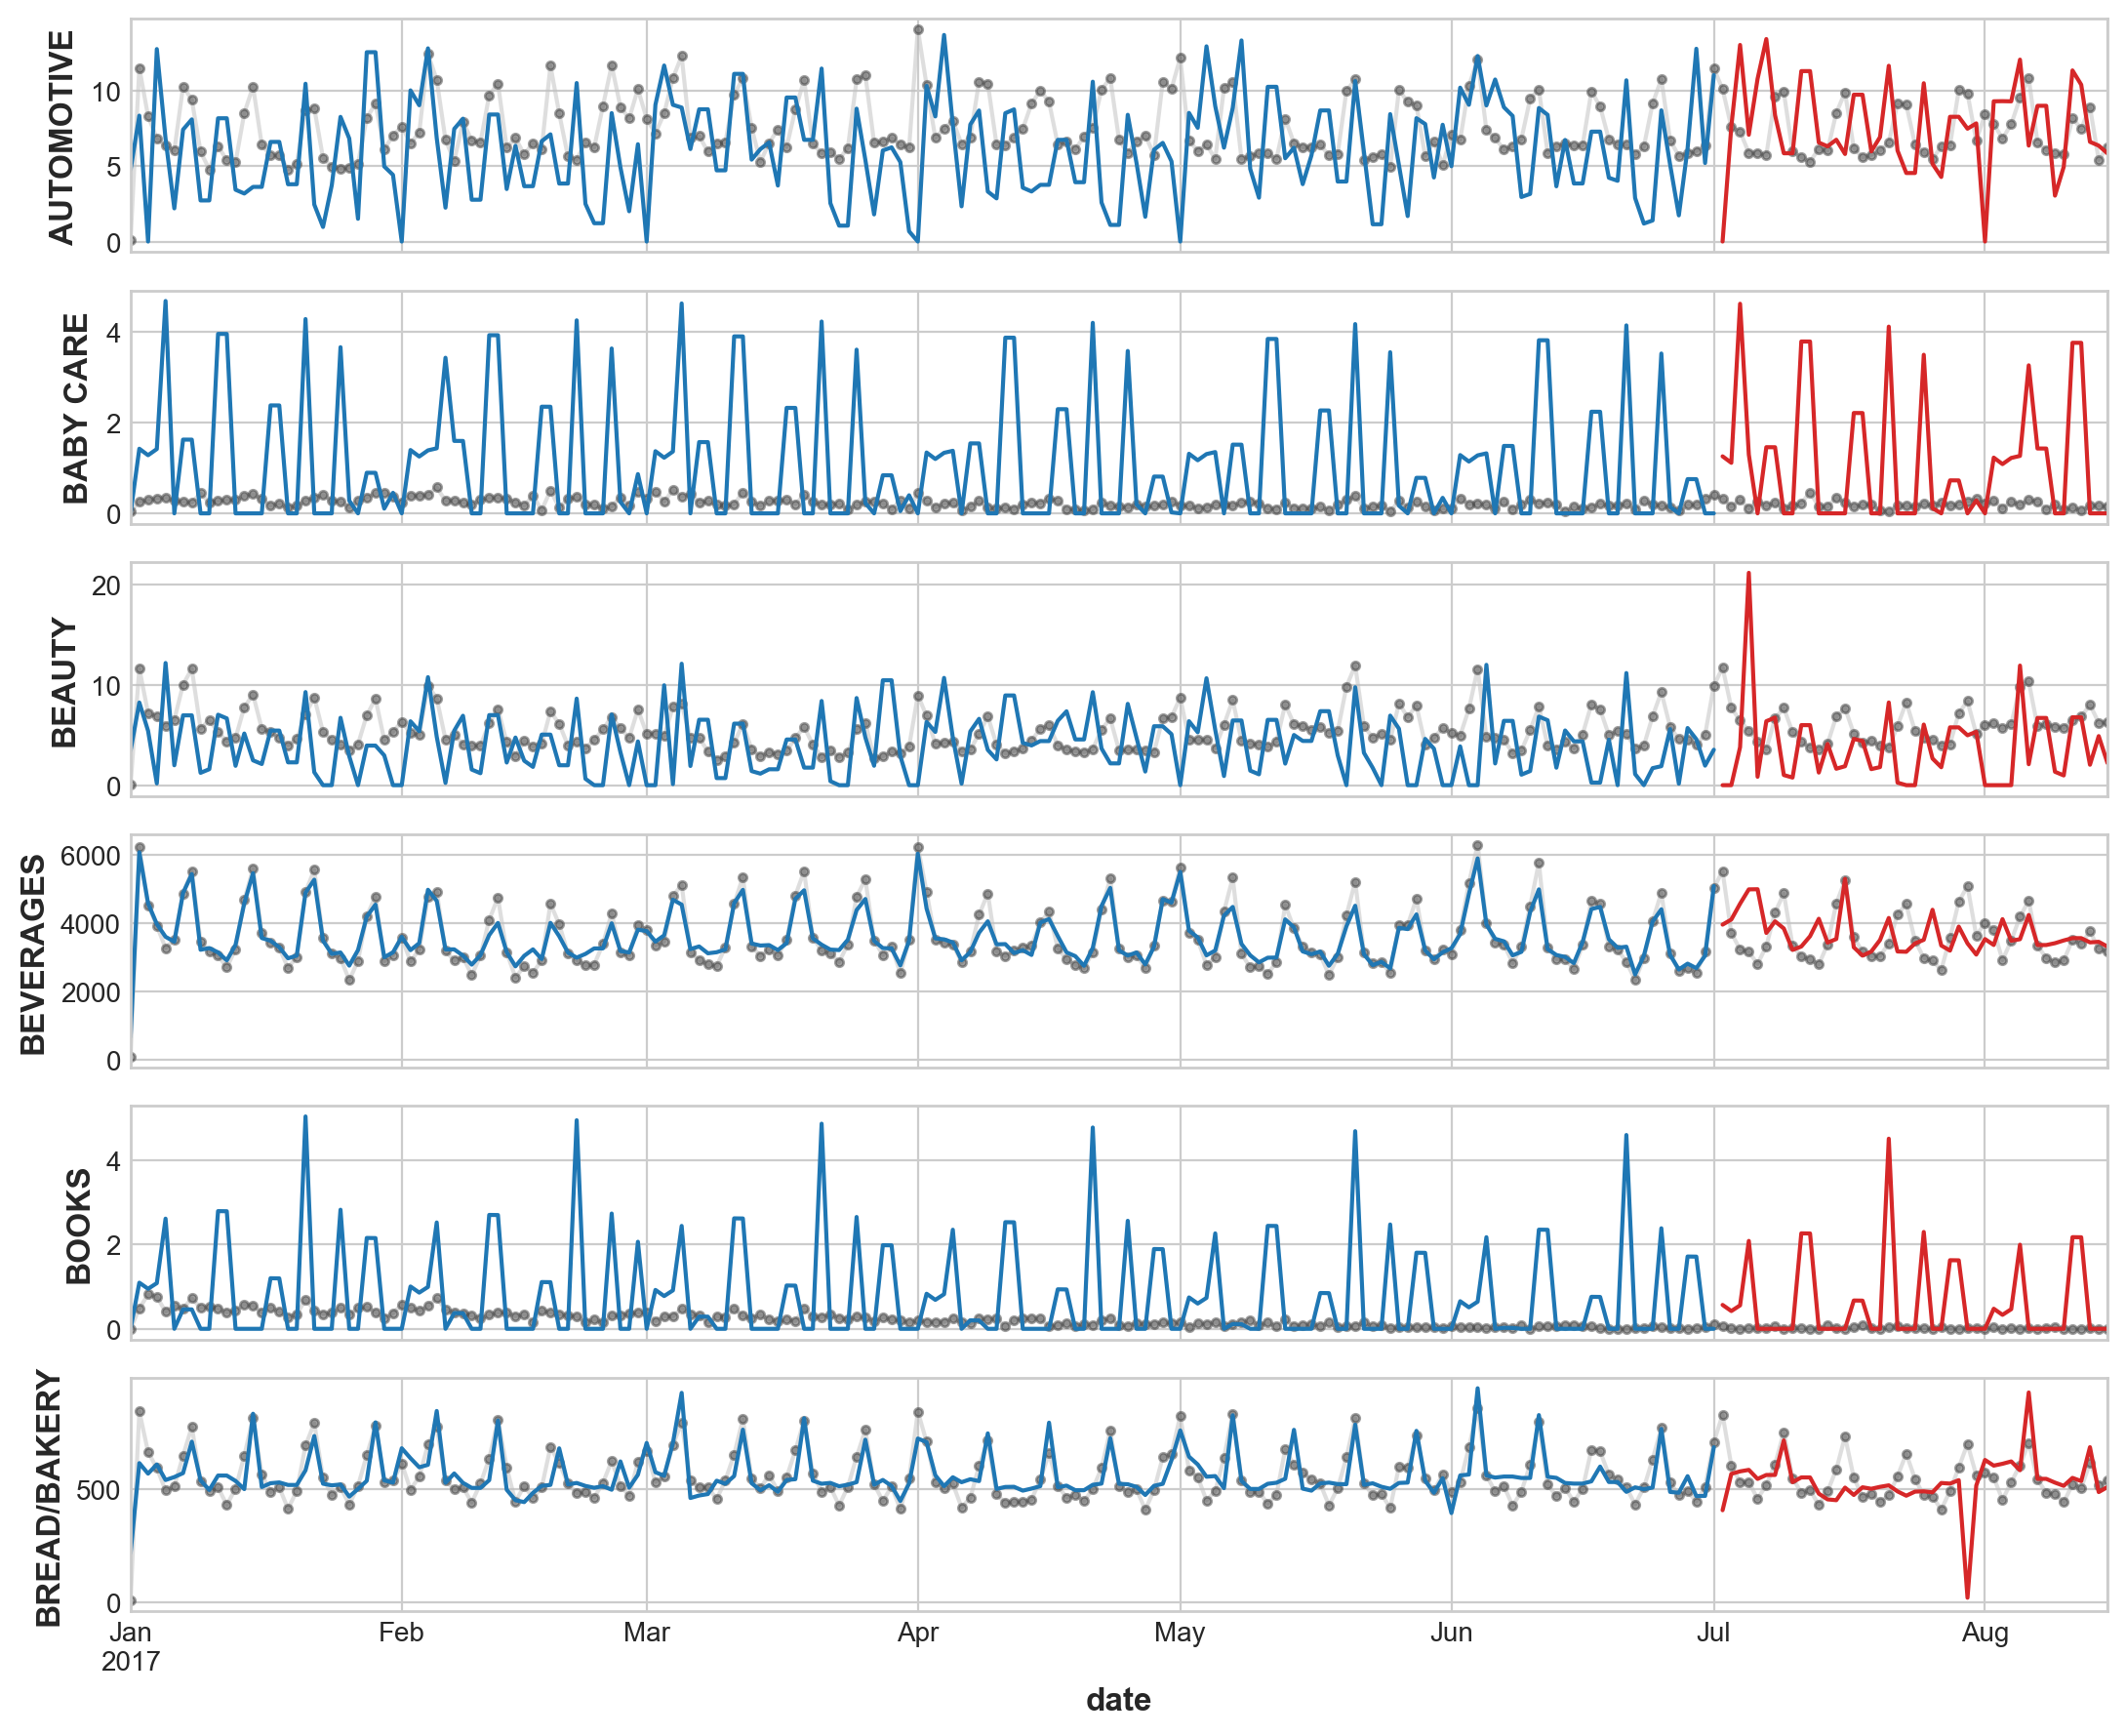

In [11]:
# confine the plots to a subset of families
families = y.columns[0:6]

axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

### Evaluate model errors

In [12]:
# calculate and display the Root Mean Squared Log error
def rmsle(y1,y2):
    '''y1 and y2 are targets to calculate error on.'''
    return mean_squared_log_error(y1, y2, squared=True)

#### Overall error

In [13]:
train_rmsle = rmsle(y_train, y_fit)
valid_rmsle = rmsle(y_valid, y_pred)
print((f"Training RMSLE: {train_rmsle:.4f}\n" f"Test RMSLE: {valid_rmsle:.4f}"))

Training RMSLE: 0.3516
Test RMSLE: 0.4260


#### Per family error

In [14]:
for family in families:
    train_rmsle = rmsle(y_train[family], y_fit[family])
    valid_rmsle = rmsle(y_valid[family], y_pred[family])
    print((f"{family} Training RMSLE: {train_rmsle:.4f}\n" f"{family} Test RMSLE: {valid_rmsle:.4f}"))
    print()

AUTOMOTIVE Training RMSLE: 0.4855
AUTOMOTIVE Test RMSLE: 0.3613

BABY CARE Training RMSLE: 0.4671
BABY CARE Test RMSLE: 0.5140

BEAUTY Training RMSLE: 0.8945
BEAUTY Test RMSLE: 1.2458

BEVERAGES Training RMSLE: 0.0311
BEVERAGES Test RMSLE: 0.0488

BOOKS Training RMSLE: 0.3331
BOOKS Test RMSLE: 0.3351

BREAD/BAKERY Training RMSLE: 0.0658
BREAD/BAKERY Test RMSLE: 0.2913



-------------------------------------------------------------------------------

Depending on your problem, you might want to use other hybrid combinations than the linear regression + XGBoost hybrid you've created in the previous questions. Run the next cell to try other algorithms from scikit-learn.

In [15]:
# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2 (detrended)
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

In [16]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1.loc[: "2017-07-01"], X_1.loc["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

### Plot

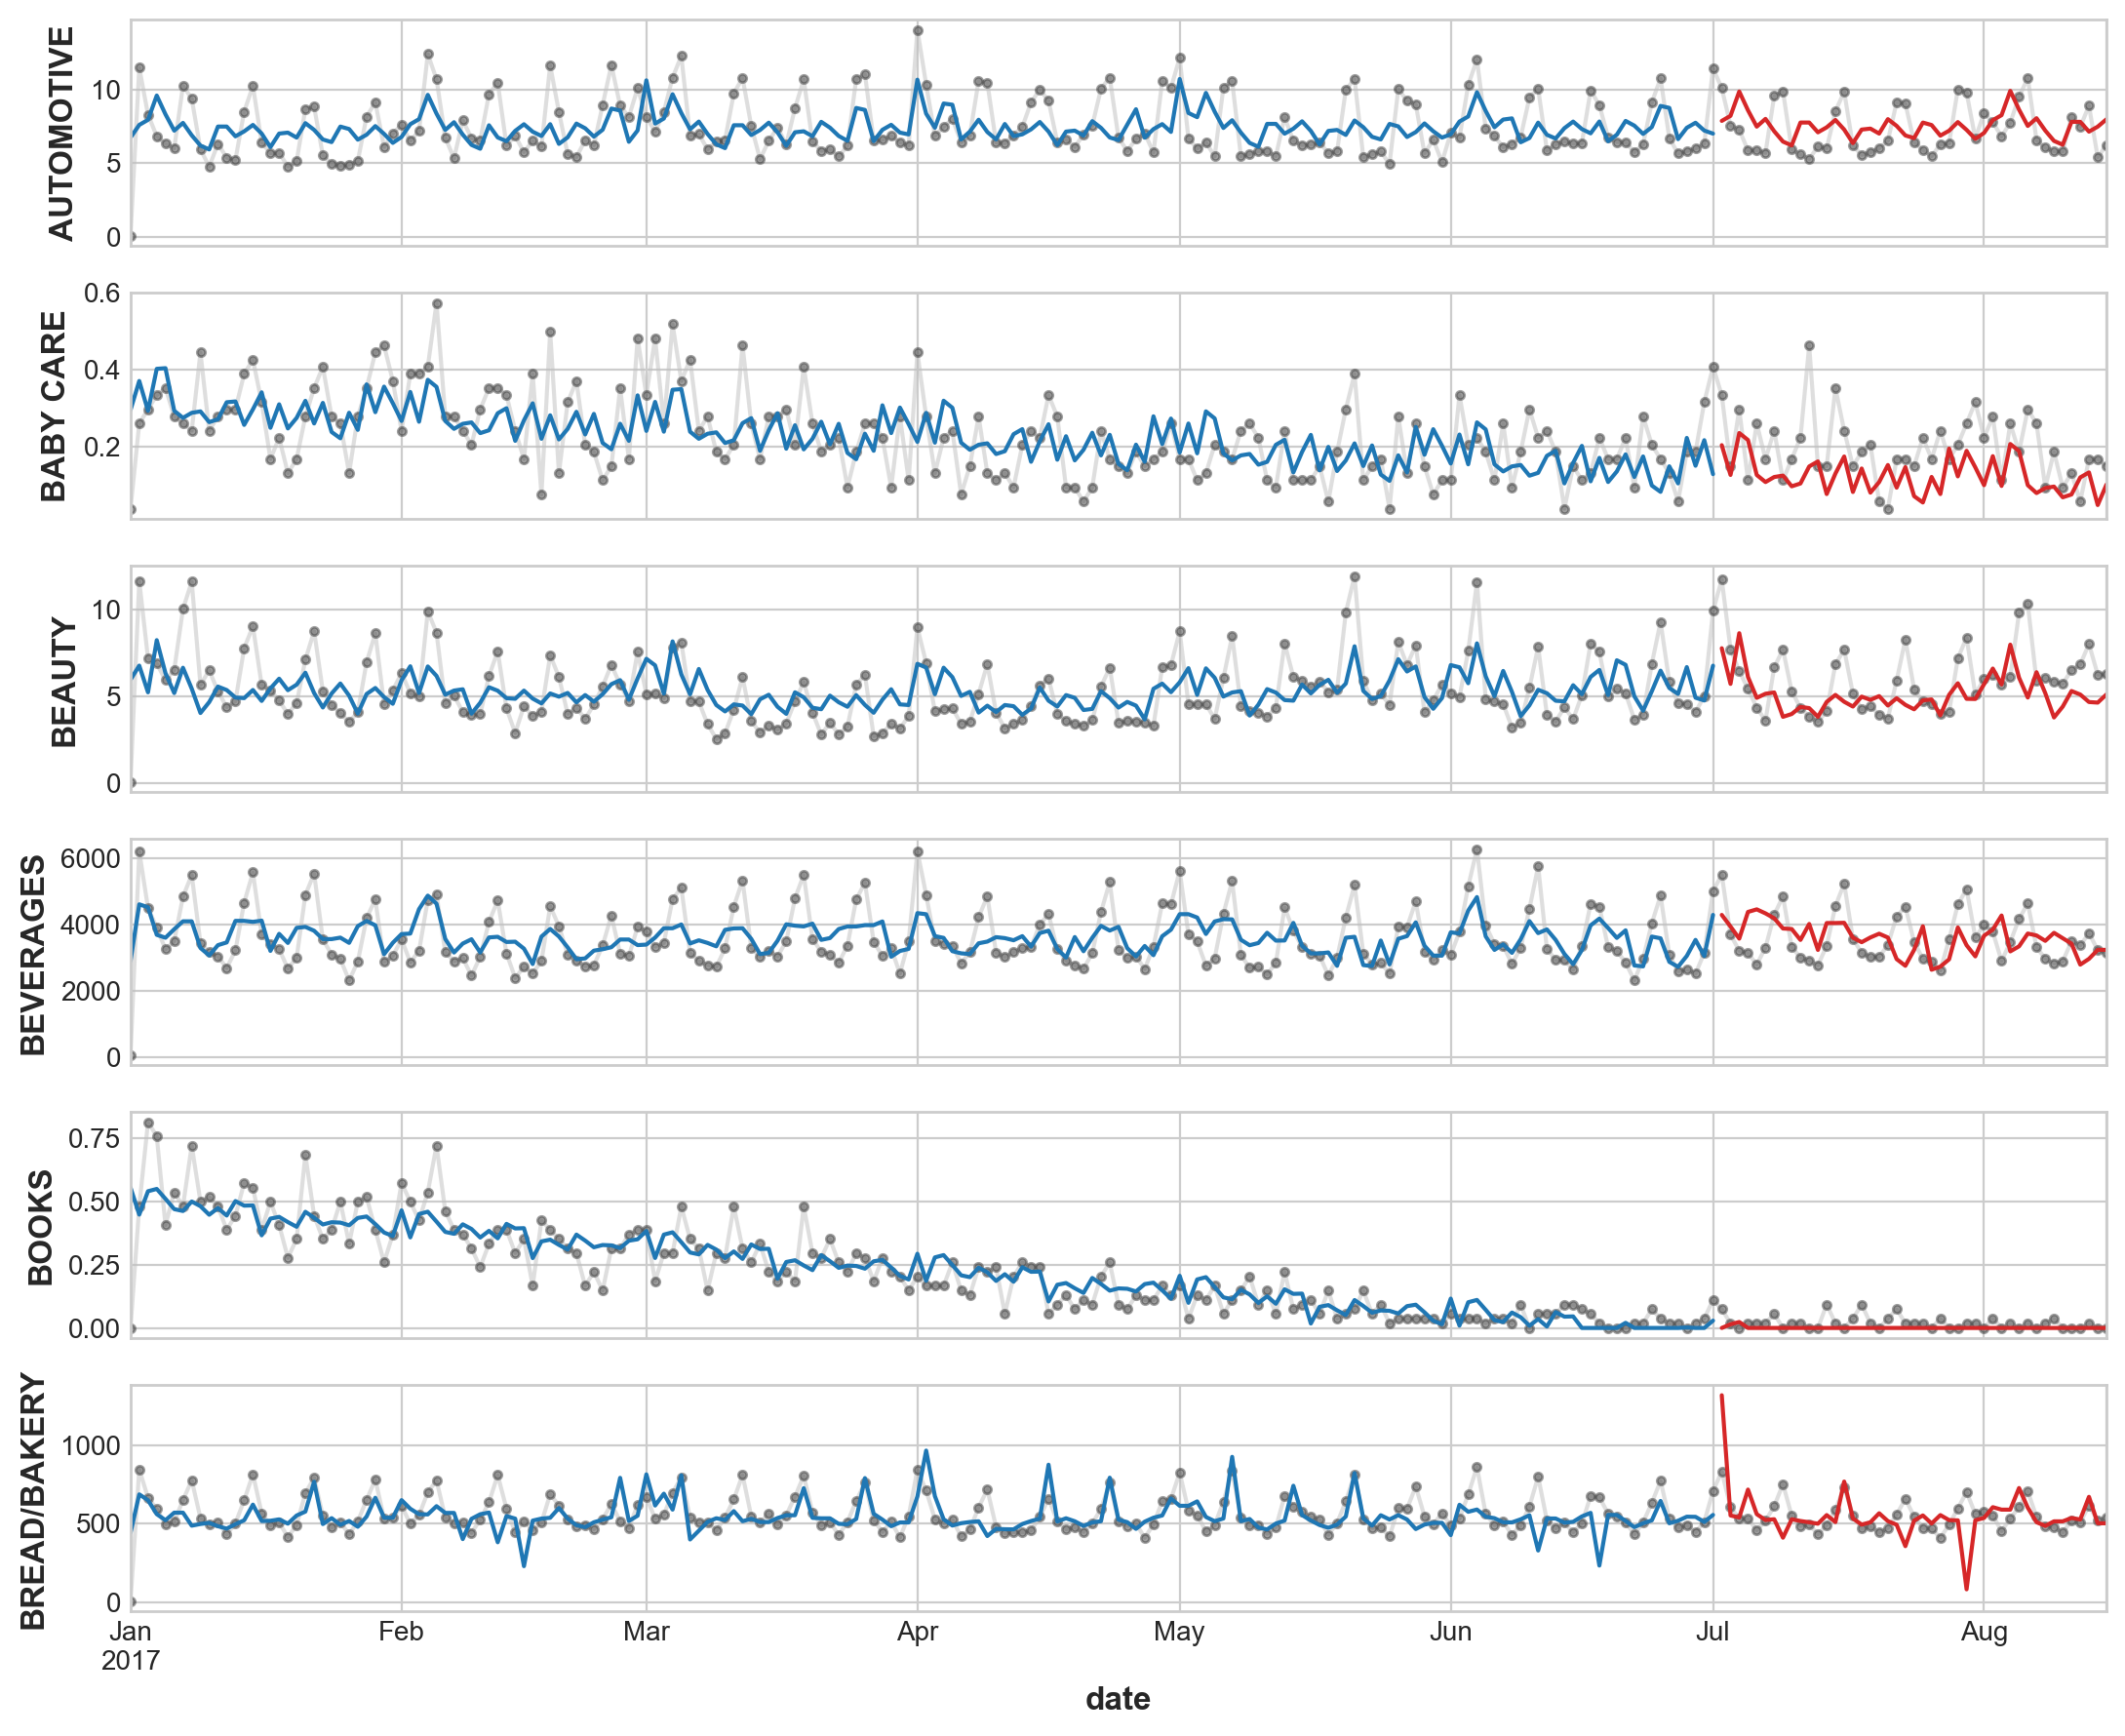

In [17]:
families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

### Evaluate model errors

#### Overall errors

In [18]:
train_rmsle = rmsle(y_train, y_fit)
valid_rmsle = rmsle(y_valid, y_pred)
print((f"Training RMSLE: {train_rmsle:.4f}\n" f"Test RMSLE: {valid_rmsle:.4f}"))

Training RMSLE: 0.1794
Test RMSLE: 0.1986


The previous hybrid model had the following errors:
- Training RMSLE: 0.3516
- Test RMSLE: 0.4260

So the current hybrid is about twice as accurate.

#### Per family errors

In [19]:
for family in families:
    train_rmsle = rmsle(y_train[family], y_fit[family])
    valid_rmsle = rmsle(y_valid[family], y_pred[family])
    print((f"{family} Training RMSLE: {train_rmsle:.4f}\n" f"{family} Test RMSLE: {valid_rmsle:.4f}"))
    print()

AUTOMOTIVE Training RMSLE: 0.0617
AUTOMOTIVE Test RMSLE: 0.0415

BABY CARE Training RMSLE: 0.0054
BABY CARE Test RMSLE: 0.0083

BEAUTY Training RMSLE: 0.0760
BEAUTY Test RMSLE: 0.0690

BEVERAGES Training RMSLE: 0.1063
BEVERAGES Test RMSLE: 0.0478

BOOKS Training RMSLE: 0.0044
BOOKS Test RMSLE: 0.0009

BREAD/BAKERY Training RMSLE: 0.1175
BREAD/BAKERY Test RMSLE: 0.1353



The previous hybrid model had the following errors:
- AUTOMOTIVE
    - Training RMSLE: 0.4855
    - Test RMSLE: 0.3613

`This model for AUTOMOTIVE is an order of magnitude better`

- BABY CARE
    - Training RMSLE: 0.4671
    - Test RMSLE: 0.5140

`This model for BABY CARE is two orders of magnitude better`

- BEAUTY 
    - Training RMSLE: 0.8945 
    - Test RMSLE: 1.2458

`This model for BEAUTY is one order of magnitude better for training, two for test`

- BEVERAGES 
    - Training RMSLE: 0.0311
    - Test RMSLE: 0.0488

`This model for BEVERAGES is an order of magnitude worse for training, about the same for test`

- BOOKS 
    - Training RMSLE: 0.3331
    - Test RMSLE: 0.3351

`This model for BOOKS is two orders of magnitude better for training, three better for test`

- BREAD/BAKERY 
    - Training RMSLE: 0.0658
    - Test RMSLE: 0.2913
    
`This model for BREAD/BAKERY is an order of magnitude worse for training, but about twice as good for test`

# Keep Going #

[**Convert any forecasting task**](https://www.kaggle.com/ryanholbrook/forecasting-with-machine-learning) to a machine learning problem with four ML forecasting strategies.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*